# EDA: Sychrony detection for classroom activities

File: 'core_classroom_analysis.py'

Checkpoint: 1

## Load data

In [1]:
pkl_filepath = '/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/core_classroom_analysis_cp1.pkl'

In [2]:
from pprint import pprint
import pandas as pd
import numpy as np
import datetime

from dask import dataframe as dd
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

In [3]:
# Load checkpoint shelve
import pickle
with open(pkl_filepath, 'rb') as f:
    inparams = pickle.load(f)

user_activity_blocks_df = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_user_activity_blocks_df.pkl')
jos_users = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_jos_users.pkl')
toolrun_df = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_toolrun_df.pkl')
cluster_output_candidate = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_cluster_output_candidate.pkl')
detected_clusters_df = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_detected_clusters_df.pkl')

cluster_post_sychrony = pd.read_pickle('/home/wang159/nanoHUB/projects/online_users_ts_analysis/temp/cp1_cluster_post_sychrony.pkl')        

In [4]:
cluster_post_sychrony

,user,tool,start,end,ip,lon,lat,cluster,scanned_date,user_meet_class_size_min,DBSCAN
0,mklingse,jmoltool,2018-01-13,2018-01-17,162.221.219.46,-86.9256,40.4444,0,2018-01-14,True,0
1,dinino,jmoltool,2018-01-14,2018-01-19,208.38.231.230,-86.9256,40.4444,0,2018-01-14,True,0
2,rleather,jmoltool,2018-01-13,2018-01-17,162.221.219.46,-86.9256,40.4444,0,2018-01-14,True,0
3,titus9,jmoltool,2018-01-10,2018-01-14,128.46.207.85,-86.9147,40.4251,0,2018-01-14,True,0
4,dtisdale,jmoltool,2018-01-15,2018-01-20,73.103.81.239,-86.9256,40.4444,0,2018-01-15,True,0
...,...,...,...,...,...,...,...,...,...,...,...
26684,quanyuhui,workspace,2018-04-16,2018-04-22,202.125.195.7,114.15,22.2909,1,2018-04-17,True,0
26685,yxlyu,workspace,2018-04-12,2018-04-17,158.132.183.229,114.167,22.25,1,2018-04-17,True,0
26686,yingyr,workspace,2018-04-16,2018-04-20,175.159.22.15,114.15,22.2909,1,2018-04-17,True,0
26687,mmh,workspace,2018-04-18,2018-04-22,128.46.16.10,-86.9147,40.4251,1,2018-04-18,True,0


## Form super-clusters by merging individual clusters

In [26]:
def user_to_group_clusters(user_group, min_size):
    '''
    Form a group clusters from individual user activity blocks
    '''
    
    # remove group clusters that are smaller than minimal size
    if user_group.shape[0] < min_size:
        return None
    
    user_set = user_group.user.unique()
    ip_set = user_group.ip.unique()
    mean_lon = user_group.lon.mean()
    mean_lat = user_group.lat.mean()
    #return pd.DataFrame([set(user_set), mean_lon, mean_lat], columns=['user_set', 'mean_lon', 'mean_lat'])    
    return pd.DataFrame([[set(user_set), mean_lon, mean_lat, set(ip_set)]], columns=['user_set', 'mean_lon', 'mean_lat', 'ip_set'])
    
    

In [27]:
# transform individual user's clusters into group cluster identified by scanned_date, tool, cluster, and DBSCAN
group_clusters = cluster_post_sychrony.groupby(['tool', 'cluster', 'scanned_date','DBSCAN']) \
                                      .apply(user_to_group_clusters, min_size=inparams[0].class_size_min) \
                                      .reset_index()
    
# series containing each group cluster in rows
#group_clusters = group_clusters.rename('group').to_frame()

display(group_clusters)

,tool,cluster,scanned_date,DBSCAN,level_4,user_set,mean_lon,mean_lat,ip_set
0,1dfdmht,0,2018-03-13,0,0,"{gustaver, millep2, smita22, pinneya, leeea2, ...",-86.792550,36.150389,"{129.59.122.17, 129.59.122.19, 129.59.122.10, ..."
1,1dfdmht,0,2018-03-14,0,0,"{gustaver, millep2, smita22, pinneya, leeea2, ...",-86.792550,36.150389,"{129.59.122.17, 129.59.122.19, 129.59.122.10, ..."
2,1dfdmht,0,2018-03-15,0,0,"{stsai19, crispeds, pinneya, leeea2, gw014425,...",-86.792521,36.150447,"{129.59.122.17, 129.59.122.19, 129.59.122.10, ..."
3,1dfdmht,0,2018-03-16,0,0,"{stsai19, crispeds, pinneya, leeea2, gw014425,...",-86.792521,36.150447,"{129.59.122.17, 129.59.122.19, 129.59.122.10, ..."
4,1dfdmht,0,2018-03-17,0,0,"{alexroed, stsai19, crispeds, pinneya, leeea2,...",-86.792200,36.151280,"{129.59.122.17, 129.59.122.19, 136.58.50.213, ..."
...,...,...,...,...,...,...,...,...,...
1861,wulffman,0,2018-02-27,0,0,"{jz854, zw475, zs347, njt47, jcs694, ecd74, un...",-76.490427,42.444809,"{128.84.125.85, 67.241.66.213, 128.84.126.88, ..."
1862,wulffman,0,2018-02-28,0,0,"{jz854, zw475, zs347, njt47, jcs694, uniqu123,...",-76.489620,42.445120,"{128.84.125.85, 67.241.66.213, 128.84.126.88, ..."
1863,wulffman,0,2018-03-01,0,0,"{jz854, zw475, zs347, njt47, jcs694, uniqu123,...",-76.488633,42.445500,"{128.84.125.85, 67.241.66.213, 128.84.126.88, ..."
1864,wulffman,0,2018-03-02,0,0,"{jz854, zw475, zs347, njt47, jcs694, uniqu123,...",-76.488633,42.445500,"{67.241.66.213, 128.84.124.166, 128.84.124.89,..."


In [28]:
group_clusters[group_clusters.tool=='pntoy']

,tool,cluster,scanned_date,DBSCAN,level_4,user_set,mean_lon,mean_lat,ip_set
1176,pntoy,0,2018-03-05,0,0,"{sohelrana, kkumaarpradeep18, abayneh, mdfaisa...",-116.252567,43.479583,"{132.178.207.7, 159.118.112.238, 132.178.128.1..."
1177,pntoy,0,2018-03-06,0,0,"{sohelrana, kkumaarpradeep18, abayneh, shafaqk...",-116.243886,43.495143,"{132.178.207.7, 159.118.112.238, 132.178.128.1..."
1178,pntoy,0,2018-03-07,0,0,"{sohelrana, kkumaarpradeep18, sarasedighi, aba...",-116.243911,43.487311,"{132.178.207.7, 159.118.112.238, 132.178.128.1..."
1179,pntoy,0,2018-03-08,0,0,"{sohelrana, kkumaarpradeep18, sarasedighi, aba...",-116.243911,43.487311,"{132.178.207.7, 159.118.112.238, 132.178.128.1..."
1180,pntoy,0,2018-03-09,0,0,"{sohelrana, kkumaarpradeep18, sarasedighi, aba...",-116.243911,43.487311,"{132.178.207.7, 159.118.112.238, 132.178.128.1..."
...,...,...,...,...,...,...,...,...,...
1250,pntoy,4,2018-04-19,0,0,"{nazanintakbiri, dchitkara, fairytail, aliyaqu...",-72.525107,42.394727,"{128.119.86.71, 128.119.82.157, 128.119.151.13..."
1251,pntoy,5,2018-04-13,0,0,"{nazanintakbiri, awaingade, fairytail, fatemeh...",-72.524800,42.391900,"{128.119.151.137, 128.119.88.191, 128.119.82.2..."
1252,pntoy,7,2018-04-14,0,0,"{lidia, anase1994, amarincaba, adrianrubio, ce...",-3.599200,37.178400,"{150.214.205.57, 150.214.194.71, 150.214.194.7..."
1253,pntoy,7,2018-04-14,1,0,"{luis93, marialo, antoniojema, f42rodim, camac...",-3.599200,37.178400,"{150.214.205.57, 150.214.194.73, 150.214.194.71}"


In [30]:
def find_mergable_clusters(this_merged_user_set, this_user_set):
    '''
    Given each merged cluster from previous day, find if there is any
    clusters that can be merged on this day
    '''    
    #display(this_merged_user_set)
    #display(this_user_set)
    
    common_set = this_user_set.intersection(this_merged_user_set)
    
    
    merged_size = len(this_merged_user_set)
    this_size = len(this_user_set)
    common_size = len(common_set)
    
    if merged_size*this_size*common_size == 0:
        # if any of these is empty, do not merge
        return 0
    
    # see if this common_set is at least 80% of the smaller set
    if merged_size >= this_size:
        share_ratio = common_size/this_size
    else:
        share_ratio = common_size/merged_size
    
    return share_ratio




def intra_tool_cluster_annex(one_tool_clusters):
    '''
    Joining clusters togethers if they:
    1. adjacent in time
    2. of same tool (one_tool_clusters only contains 1 tool anyway)
    3. shares 80% of same users at least by one cluster 
    '''
    
    # create empty df for merged clusters
    merged_tool_clusters = pd.DataFrame(columns=['start', 'end', 'mean_lon', 'mean_lat', 'user_set', 'ip_set'])
    
    # time range the cluster covered
    start_date = one_tool_clusters.scanned_date.min()
    end_date = one_tool_clusters.scanned_date.max()
    
    date_list = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date-start_date).days)]
    
    # begin to annex clusters day by day
    for this_date in date_list:
        # for each date
        
        # tool, date
        this_date_clusters = one_tool_clusters[one_tool_clusters.scanned_date == this_date]
        
        # tool, date, cluster, DBSCAN uniquely identifies a cluster
        
        # mergable clusters on this date
        this_date_merged_tool_clusters = merged_tool_clusters[merged_tool_clusters.end == (this_date-datetime.timedelta(days=1))]
        
        # iterate over this_date_clusters, and 
        # 1. merge the mergable clusters with merged_tool_clusters
        # 2. append the new clusters if not mergable
        for row in this_date_clusters.itertuples():        
            this_user_set = row.user_set
            result = this_date_merged_tool_clusters.user_set.apply(find_mergable_clusters, this_user_set = this_user_set)
            
            # find the results above the cutoff. Should only have 1
            to_merge = False
            if not result.empty:
                # some scores are found
                max_score_index = result.idxmax()
            
                if result[max_score_index] >= 0.5:
                    # maximum similiarty exceeds threshold                    
                    to_merge = True
    
            if to_merge:
                # merge
                
                merged_user_total = len(merged_tool_clusters.loc[max_score_index].user_set)
                this_user_total = len(row.user_set)
                
                merged_tool_clusters.at[max_score_index, 'end'] = row.scanned_date  
                
                merged_tool_clusters.at[max_score_index, 'mean_lon'] = \
                    (row.mean_lon*this_user_total + merged_tool_clusters.loc[max_score_index].mean_lon*merged_user_total) \
                    / (this_user_total + merged_user_total)
                
                merged_tool_clusters.at[max_score_index, 'mean_lat'] = \
                    (row.mean_lat*this_user_total + merged_tool_clusters.loc[max_score_index].mean_lat*merged_user_total) \
                    / (this_user_total + merged_user_total)
                
                merged_tool_clusters.at[max_score_index, 'user_set'] = \
                    merged_tool_clusters.loc[max_score_index].user_set.union(row.user_set)

                merged_tool_clusters.at[max_score_index, 'ip_set'] = \
                    merged_tool_clusters.loc[max_score_index].ip_set.union(row.ip_set)                
            else:
                # append
                merged_tool_clusters = merged_tool_clusters.append({'start':row.scanned_date, \
                                                        'end':row.scanned_date, \
                                                        'mean_lon':row.mean_lon, \
                                                        'mean_lat':row.mean_lat, \
                                                        'user_set':row.user_set,\
                                                        'ip_set':row.ip_set\
                                                        }, ignore_index=True)
  
    return merged_tool_clusters

In [31]:
# group by tool names and dispatch for intra-tool cluster annex
#test_df = group_clusters[group_clusters.scanned_date < datetime.datetime(2018,3,17)].groupby('tool').apply(intra_tool_cluster_annex)

intra_tool_cluster_df = dd.from_pandas(group_clusters, npartitions=30) \
                          .groupby('tool') \
                          .apply(intra_tool_cluster_annex, \
                                 meta = pd.DataFrame(columns=['start', 'end', 'mean_lon', 'mean_lat', 'user_set', 'ip_set']) \
                                ) \
                          .compute(scheduler=inparams[0].dask_scheduler)


[########################################] | 100% Completed |  1.6s


In [32]:
intra_tool_cluster_df

start        end    mean_lon   mean_lat  \
tool                                                       
jmoltool  0 2018-01-15 2018-01-21  -86.918438  40.431718   
          1 2018-02-05 2018-02-09  -86.917190  40.429510   
          2 2018-02-26 2018-03-02  -86.918942  40.432611   
          3 2018-04-11 2018-04-12  -86.919060  40.432820   
          4 2018-04-12 2018-04-13  -86.919060  40.432820   
...                ...        ...         ...        ...   
workspace 4 2018-02-06 2018-02-10  -86.908718  40.398418   
          5 2018-02-09 2018-02-10  -86.903150  40.400600   
          6 2018-03-02 2018-03-06  114.160883  22.272925   
          7 2018-03-08 2018-03-13  114.154331  22.280670   
          8 2018-04-13 2018-04-13  114.163340  22.276360   

                                                      user_set  \
tool                                                             
jmoltool  0  {pangn, iaranadi, zhan2536, dtisdale, wu801, a...   
          1  {clark485, mtan05280528, ray76, su107, nmacke,...   
          2  {faltens, tarabear1313, dtisdale, owellbor, sa...   
          3   {hong224, davids19, mason92, rleather, mklingse}   
          4  {mserewic, zhan2536, white494, owellbor, kline40}   
...                                                        ...   
workspace 4  {rheiland, mathcancer, jasakadu, pmeunier, sun...   
          5  {rheiland, proycho, anshaikh, aperna, jmstout2...   
          6  {ironmanfederer, yxlyu, liyuanzhe123, kenko911...   
          7  {kotszwai, liyuanzhe123, kenko911, renben, yin...   
          8  {yxlyu, liyuanzhe123, yingyr, quanyuhui, nonof...   

                                                        ip_set  
tool                                                            
jmoltool  0  {128.211.192.84, 68.234.145.166, 128.211.224.1...  
          1  {128.46.217.34, 98.223.101.154, 128.46.217.38,...  
          2  {73.103.81.239, 128.211.218.138, 128.211.186.1...  
          3  {192.31.0.5, 69.174.137.60, 128.211.255.48, 16...  
          4  {73.103.93.47, 68.234.146.243, 128.211.218.138...  
...                                                        ...  
workspace 4  {72.12.199.50, 128.46.78.51, 192.31.0.5, 128.4...  
          5  {192.31.0.5, 128.46.190.192, 72.12.199.50, 199...  
          6  {158.132.183.239, 158.132.183.206, 175.159.15....  
          7  {203.218.38.156, 175.159.15.223, 175.159.22.12...  
          8  {175.159.15.39, 158.132.167.218, 158.132.182.2...  

[272 rows x 6 columns]

In [33]:
a = group_clusters[(group_clusters.scanned_date == datetime.datetime(2018,1,19)) & (group_clusters.tool == 'abacus')].user_set
b = group_clusters[(group_clusters.scanned_date == datetime.datetime(2018,1,20)) & (group_clusters.tool == 'abacus')].user_set

## Inter-tool clustering to form final classes

In [34]:
intra_tool_cluster_df = intra_tool_cluster_df.reset_index()

Annex rules for inter-tool clustering:
1. number of users overlapping > 5
2. Dates within a window of 4 month
3. geospatial location differ no more than 5 km

Annex in time order

In [35]:
def find_inter_mergable_clusters(this_row, intra_tool_cluster_df, time_tolerance, dist_tolerance):
    # iterate through entire intra_tool_cluster_df
    
    eligible_clusters = intra_tool_cluster_df
    
    # filter dates
    eligible_clusters = eligible_clusters[(abs(eligible_clusters.start - this_row.end) <= time_tolerance) | \
                                          (abs(eligible_clusters.end - this_row.start) <= time_tolerance)]
    
    # filter geo-location
    distance = eligible_clusters\
                .apply(lambda x: haversine_metric([x.mean_lon, x.mean_lat],\
                                                  [this_row.mean_lon, this_row.mean_lat]), \
                       axis=1)    
    eligible_clusters = eligible_clusters[distance < dist_tolerance]
    
    
    # form similarity matrix by number of users shared across
    # shared_user is a percentage (0-1). 
    shared_user = eligible_clusters.user_set\
                    .apply(lambda x: len(this_row.user_set.intersection(x))/len(this_row.user_set.union(x)))
    
    row_index = np.ones(len(shared_user.index))*int(this_row.name)
    
    return np.array([shared_user.values, row_index, shared_user.index.values])

In [36]:
time_tolerance = datetime.timedelta(days=120)
dist_tolerance = 5



similarity_tuples = intra_tool_cluster_df.apply(find_inter_mergable_clusters, \
                                        intra_tool_cluster_df = intra_tool_cluster_df, \
                                        time_tolerance = time_tolerance, \
                                        dist_tolerance = dist_tolerance, \
                                        axis=1)

In [37]:
similarity_tuples_hstack = np.hstack(similarity_tuples)
similarity_tuples_hstack[0,:]

array([1.        , 0.07692308, 0.14285714, ..., 0.5       , 0.44444444,
       1.        ])

In [38]:
similarity_tuples_hstack = np.hstack(similarity_tuples)

from scipy.sparse import coo_matrix

similarity_matrix = coo_matrix( \
                         (similarity_tuples_hstack[0,:], \
                         (similarity_tuples_hstack[1,:].astype(int), \
                          similarity_tuples_hstack[2,:].astype(int)) \
                         )).toarray()

In [39]:
from sklearn.cluster import DBSCAN

num_of_clusters = list()

cluster_result = DBSCAN(eps=5, min_samples=1, metric='precomputed').fit_predict(1/(similarity_matrix+0.0001))
num_of_clusters.append(cluster_result.max())

In [40]:
cluster_result

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        12,  13,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        23,  24,  24,  25,  26,  27,  28,  29,  30,  31,  31,  32,  33,
        33,  34,  34,  35,  36,  37,  38,  39,  39,  39,  40,  31,  41,
        42,  43,  44,  45,  46,  11,  47,  48,  49,  50,  50,  51,  12,
        52,  53,   1,   1,  54,  21,  55,  56,   8,   8,  57,  57,  58,
        59,  60,  61,  61,  33,  33,  34,  62,  63,  64,  64,  65,  66,
        67,  64,  68,  69,  69,  68,  70,  71,  71,  72,  72,  73,  74,
        75,  76,  77,  78,  79,  79,  79,  80,  21,  52,  79,  81,  82,
        83,  84,  85,  86,  87,  88,  25,  11,  29,  65,  61,  89,  90,
         8,   8,  91,  92,  92,  93,  77,  61,  94,   5,   5,  94,   5,
        95,  96,  97,  98,  29,  28,  99,  91,  92, 100, 101,  21, 102,
       103,  20, 104, 105, 105,  53, 106, 107, 108,  21,  53,  21, 109,
       110, 111,  91,  92, 112, 113,  93, 114,  21,  51,  21, 11

In [41]:
intra_tool_cluster_df.loc[cluster_result==5].user_set.values

array([{'indigocloud123', 'lanlibsu', 'naqsh.mansoor', 'muramutsa365', 'jennyfothergill', 'satture5678', 'jordanvandegrift', 'matthewgoelzer', 'stevejohns', 'victoriavolk', 'drewlysne', 'ajchristy47', 'saidarazaee', 'ehsan.moshkelgosha', 'jonhuff', 'scottbirks'},
       {'lanlibsu', 'satture5678', 'jordanvandegrift', 'drewlysne', 'ajchristy47', 'ehsan.moshkelgosha', 'scottbirks'},
       {'indigocloud123', 'lanlibsu', 'naqsh.mansoor', 'jennyfothergill', 'vallejokevin3', 'satture5678', 'jordanvandegrift', 'matthewgoelzer', 'stevejohns', 'jakesoares', 'jonhuff', 'scottbirks'},
       {'naqsh.mansoor', 'satture5678', 'jordanvandegrift', 'jakesoares', 'matthewgoelzer', 'bjkarki', 'victoriavolk', 'stevejohns', 'drewlysne', 'ajchristy47', 'katiesautter1', 'ehsan.moshkelgosha', 'jonhuff', 'scottbirks'}],
      dtype=object)

## Record class information from DBSCAN results

In [42]:
intra_tool_cluster_df

,tool,level_1,start,end,mean_lon,mean_lat,user_set,ip_set
0,jmoltool,0,2018-01-15,2018-01-21,-86.918438,40.431718,"{pangn, iaranadi, zhan2536, dtisdale, wu801, a...","{128.211.192.84, 68.234.145.166, 128.211.224.1..."
1,jmoltool,1,2018-02-05,2018-02-09,-86.917190,40.429510,"{clark485, mtan05280528, ray76, su107, nmacke,...","{128.46.217.34, 98.223.101.154, 128.46.217.38,..."
2,jmoltool,2,2018-02-26,2018-03-02,-86.918942,40.432611,"{faltens, tarabear1313, dtisdale, owellbor, sa...","{73.103.81.239, 128.211.218.138, 128.211.186.1..."
3,jmoltool,3,2018-04-11,2018-04-12,-86.919060,40.432820,"{hong224, davids19, mason92, rleather, mklingse}","{192.31.0.5, 69.174.137.60, 128.211.255.48, 16..."
4,jmoltool,4,2018-04-12,2018-04-13,-86.919060,40.432820,"{mserewic, zhan2536, white494, owellbor, kline40}","{73.103.93.47, 68.234.146.243, 128.211.218.138..."
...,...,...,...,...,...,...,...,...
267,workspace,4,2018-02-06,2018-02-10,-86.908718,40.398418,"{rheiland, mathcancer, jasakadu, pmeunier, sun...","{72.12.199.50, 128.46.78.51, 192.31.0.5, 128.4..."
268,workspace,5,2018-02-09,2018-02-10,-86.903150,40.400600,"{rheiland, proycho, anshaikh, aperna, jmstout2...","{192.31.0.5, 128.46.190.192, 72.12.199.50, 199..."
269,workspace,6,2018-03-02,2018-03-06,114.160883,22.272925,"{ironmanfederer, yxlyu, liyuanzhe123, kenko911...","{158.132.183.239, 158.132.183.206, 175.159.15...."
270,workspace,7,2018-03-08,2018-03-13,114.154331,22.280670,"{kotszwai, liyuanzhe123, kenko911, renben, yin...","{203.218.38.156, 175.159.15.223, 175.159.22.12..."


In [49]:
num_of_classes = cluster_result.max() + 1


students_info_df  = pd.DataFrame(columns=['user', 'class_id', 'parti_rate'])
class_info_df     = pd.DataFrame(columns=['class_id', 'start', 'end', 'lon', 'lat', 'size', 'ip_set'])
classtool_info_df = pd.DataFrame(columns=['toolname', 'class_id'])

for this_class_index in range(0, num_of_classes):
    
    this_class_tool_clusters = intra_tool_cluster_df.loc[cluster_result == this_class_index]
    
    # student participation rate
    # this is how many sub-clusters each student appears in
    
    all_students_list = list()
    num_total_clusters = this_class_tool_clusters.shape[0]
    
    for this_user_set in this_class_tool_clusters.user_set:
        all_students_list.extend(list(this_user_set))
    
    this_students_df = pd.DataFrame(set(all_students_list), columns=['user'])
    
    this_students_df['class_id'] = this_class_index 
    this_students_df['parti_rate'] = this_students_df.user \
                                            .apply(lambda x: all_students_list.count(x)/num_total_clusters)
    
    
    students_info_df = students_info_df.append(this_students_df, ignore_index=True)
    
    # tool list
    
    this_classtool_df = pd.DataFrame(set(this_class_tool_clusters.tool), columns=['toolname'])
    this_classtool_df['class_id'] = this_class_index
    
    classtool_info_df = classtool_info_df.append(this_classtool_df, ignore_index=True)
    
    # class general information
    
    class_info_df = class_info_df.append({'class_id':this_class_index, \
                                          'start':this_class_tool_clusters.start.min(), \
                                          'end':this_class_tool_clusters.end.max(), \
                                          'lon':this_class_tool_clusters.mean_lon.mean(), \
                                          'ip_set':this_class_tool_clusters.ip_set.values, \
                                          'lat':this_class_tool_clusters.mean_lat.mean(), \
                                          'size':len(set(all_students_list))}, ignore_index=True)
    

display(students_info_df.head())
display(class_info_df.head())
display(classtool_info_df.head())

,user,class_id,parti_rate
0,pangn,0,1.0
1,zhan2536,0,1.0
2,dtisdale,0,1.0
3,rleather,0,1.0
4,mbanerje,0,1.0


,class_id,start,end,lon,lat,size,ip_set
0,0,2018-01-15,2018-01-21,-86.918438,40.431718,18,"[{128.211.192.84, 68.234.145.166, 128.211.224...."
1,1,2018-02-05,2018-04-19,-86.916811,40.430097,45,"[{128.46.217.34, 98.223.101.154, 128.46.217.38..."
2,2,2018-02-26,2018-03-02,-86.918942,40.432611,6,"[{73.103.81.239, 128.211.218.138, 128.211.186...."
3,3,2018-04-11,2018-04-12,-86.919060,40.432820,5,"[{192.31.0.5, 69.174.137.60, 128.211.255.48, 1..."
4,4,2018-04-12,2018-04-13,-86.919060,40.432820,5,"[{73.103.93.47, 68.234.146.243, 128.211.218.13..."


,toolname,class_id
0,jmoltool,0
1,polymod,1
2,jmoltool,1
3,nanomatmech,1
4,jmoltool,2


In [52]:
class_info_df.ip_set[0]

array([{'128.211.192.84', '68.234.145.166', '128.211.224.134', '73.103.81.239', '128.211.217.254', '192.31.0.5', '68.234.144.173', '128.211.193.226', '128.211.186.10', '128.46.207.157', '128.46.194.133', '162.221.219.46', '208.38.231.230', '128.46.10.19', '72.12.194.250', '128.211.241.222'}],
      dtype=object)

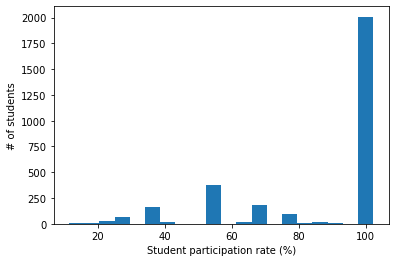

In [51]:
from matplotlib import pyplot as plt

plt.hist(students_info_df.parti_rate.values*100, 20, align='right');
plt.xlabel('Student participation rate (%)')
plt.ylabel('# of students')
#plt.ylim([0,700])

plt.show()

In [ ]:
class_info_df